In [1]:
import requests
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns

def obtain_fda_results(api_key, drug_term):
    base_url = "https://api.fda.gov/drug/event.json"
    
    # Search parameters
    params = {
        'api_key': api_key,
        'search': f'"patient.drug.medicinalproduct.exact:""{drug_term}"',
        'count': "patient.reaction.reactionmeddrapt.exact"
        }

    headers = {
        'Content-Type': 'application/json',
    }

    try:
        # Api call
        response = requests.get(base_url,  params=params, headers=headers)
        response.raise_for_status()  # Check if there are errors in the HTTP response

        # Convert the response to JSON
        data = response.json()

        # Check if 'results' is present
        if 'results' in data:
            # Return the resulting json
            return data
        else:
            print(f"There are no results for {drug_term}")
            return None
    
    except requests.exceptions.RequestException as e:
        print(f"Error in the api call for {drug_term}: {e}")

def obtain_fda_results_from_list(api_key, drugs):
    
    df_results = pd.DataFrame(columns=['drug', 'term', 'count'])

    for drug in drugs['drug']:
        data = obtain_fda_results(api_key,drug)
        
        # Check if 'results' is present in data
        if data is not None and 'results' in data:
            # Create a DataFrame for the current drug's results
            df_drug = pd.DataFrame(data['results'])
            df_drug['drug'] = drug
            
            # Concatenate to the main DataFrame
            df_results = pd.concat([df_results, df_drug], ignore_index=True)
        
        # Add a 1 second delay
        time.sleep(1)

    return df_results

In [2]:
#Function for data  preprocessing

def data_preprocessing(results_df, rows = "drug", columns = "term", cellValues = "count", num_top_events = 12):
    #Preprocessing of the dataframe

    # We use the pivot_table function (handles duplicates) to convert the long DataFrame to a wide one
    results_df_wide = results_df.pivot_table(index=rows, columns=columns, values=cellValues)

    # We remove the drug label as a column name
    results_df_wide.columns.name = None

    # We reset the indices so that the tumor type and the drug names are at the same level
    results_df_wide.reset_index(inplace=True)

    # We extract the 12 events with the highest number of results in the bibliography. Independently of the tumor type
    top_events = results_df_wide.drop(columns=[rows]).sum().sort_values(ascending=False).head(num_top_events)

    # We filter the dataframe to keep only the tumor type column and the drugs with the most results
    results_df_wide = results_df_wide[[rows] + list(top_events.index)]

    # We define the tumor type as the indices of the dataframe
    results_df_wide.set_index(rows, inplace=True)

    # We sum the total number of results of the 15 drugs for each tumor type and create a new column called 'TotalResults'
    results_df_wide['TotalResults'] = results_df_wide[list(top_events.index)].sum(axis=1)

    # We sort the dataframe by the new column 'TotalResults' in descending order
    results_df_wide = results_df_wide.sort_values(by='TotalResults', ascending=False).reset_index()
    results_df_wide = results_df_wide[[rows] + list(top_events.index)]
    results_df_wide.set_index(rows, inplace=True)

    results_df = results_df_wide.fillna(0)
    
    return results_df, top_events

def bar_plot_results(results_df_wide, top_events, num_columns = 25, xlab = 'Drugs', 
                     plot_title ='Drugs and adverse effects. Source:Faers', legend_title = 'Adverse effects'):
    # Visualize the results of each drug in function of the tumor type

    # Configure the unique color palette for each drug with Seaborn
    colors = sns.color_palette("Set3", n_colors=len(top_events))

    # We create a stacked bar plot
    ax = results_df_wide.head(num_columns).plot(kind='bar', stacked=True, figsize=(10, 6), color = colors, width=0.8)

    # We add labels and title
    ax.set_xlabel(xlab, fontsize=12)
    ax.set_ylabel('Number of Results', fontsize=12)
    ax.set_title(plot_title, fontsize=14)
    ax.legend(title= legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')  # Place the legend to the right
    plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels
    plt.tight_layout()  # Adjust the layout of the plot
    plt.show()

In [3]:
# Reemplaza 'tu_token_aqui' con tu token real
token_api = 'pqnh6L01FAfMHzGvbu6PoEXoHoqQLIXFgxWCAaoH'
drug_term = 'ipilimumab'

response= obtain_fda_results(token_api, drug_term)


In [5]:
with open('../results/output.json', 'w', encoding='utf-8') as f:
            json.dump(response, f, ensure_ascii=False, indent=2)

In [6]:
token_api = 'pqnh6L01FAfMHzGvbu6PoEXoHoqQLIXFgxWCAaoH'
drugs = pd.read_csv("../data/drugs.csv", header = None, names = ['drug'])

In [ ]:
results = obtain_fda_results_from_list(token_api, drugs)
results

Error in the api call for emtansine trastuzumab: 404 Client Error: Not Found for url: https://api.fda.gov/drug/event.json?api_key=pqnh6L01FAfMHzGvbu6PoEXoHoqQLIXFgxWCAaoH&search=%22patient.drug.medicinalproduct.exact%3A%22%22emtansine+trastuzumab%22&count=patient.reaction.reactionmeddrapt.exact
Error in the api call for deruxtecan trastuzumab: 404 Client Error: Not Found for url: https://api.fda.gov/drug/event.json?api_key=pqnh6L01FAfMHzGvbu6PoEXoHoqQLIXFgxWCAaoH&search=%22patient.drug.medicinalproduct.exact%3A%22%22deruxtecan+trastuzumab%22&count=patient.reaction.reactionmeddrapt.exact


In [20]:
# Save the search results in pubmed in .csv
results.to_csv('resultados_faers.csv', index=False)

In [8]:
# Load data from Faers 
results_df = pd.read_csv('../results/resultados_faers.csv')
results_df = results_df.fillna(0)

In [17]:
results_df

farmaco                            term  count
0     pembrolizumab  MALIGNANT NEOPLASM PROGRESSION   7917
1     pembrolizumab                           DEATH   4111
2     pembrolizumab                       DIARRHOEA   3462
3     pembrolizumab                         FATIGUE   3389
4     pembrolizumab                   OFF LABEL USE   3002
...             ...                             ...    ...
6195      sotorasib    LIVER FUNCTION TEST ABNORMAL      7
6196      sotorasib              METASTASES TO BONE      7
6197      sotorasib                   MUSCLE SPASMS      7
6198      sotorasib              NEOPLASM MALIGNANT      7
6199      sotorasib        PLATELET COUNT DECREASED      7

[6200 rows x 3 columns]

In [19]:
adverse_effects = pd.read_csv("../data/adverse_effects.csv")
retain_columns = list(adverse_effects[adverse_effects.columns[0]])
retain_columns

['dysphagia']

In [20]:
results_df[results_df['term'].str.lower().isin([adverse_effect.lower() for adverse_effect in retain_columns])]

farmaco       term  count
79            pembrolizumab  DYSPHAGIA    425
158             osimertinib  DYSPHAGIA    112
283               nivolumab  DYSPHAGIA    493
385             abemaciclib  DYSPHAGIA     60
646               alectinib  DYSPHAGIA     56
733              dabrafenib  DYSPHAGIA    259
1063           cabozantinib  DYSPHAGIA    336
1171            ramucirumab  DYSPHAGIA     40
1291           atezolizumab  DYSPHAGIA    154
1460               olaparib  DYSPHAGIA    101
1541             trametinib  DYSPHAGIA    226
1680             ribociclib  DYSPHAGIA    260
1872             lenvatinib  DYSPHAGIA    225
1981            palbociclib  DYSPHAGIA    711
2330             crizotinib  DYSPHAGIA    175
2591               avelumab  DYSPHAGIA     18
2670             lorlatinib  DYSPHAGIA     31
2722           enzalutamide  DYSPHAGIA   1236
2844               afatinib  DYSPHAGIA     83
2963           capecitabine  DYSPHAGIA    868
3026              cetuximab  DYSPHAGIA    586
3179     paclitaxel albumin  DYSPHAGIA      6
3358  sacituzumab govitecan  DYSPHAGIA     29
3593             paclitaxel  DYSPHAGIA    701
3733            encorafenib  DYSPHAGIA     86
3891             everolimus  DYSPHAGIA    398
3991            vinorelbine  DYSPHAGIA     92
4076             pemetrexed  DYSPHAGIA    226
4150            binimetinib  DYSPHAGIA     57
4272            carboplatin  DYSPHAGIA    966
4337            abiraterone  DYSPHAGIA    403
4591             everolimus  DYSPHAGIA    398
4767           fluorouracil  DYSPHAGIA    717
5084            regorafenib  DYSPHAGIA    105
5146          selpercatinib  DYSPHAGIA      8
5494             irinotecan  DYSPHAGIA    274
5747              alpelisib  DYSPHAGIA     92
5968           temozolomide  DYSPHAGIA    187
6073            oxaliplatin  DYSPHAGIA    607
6191              sotorasib  DYSPHAGIA      7

In [9]:
results_df_wide, top_farmacos = data_preprocessing(results_df)
results_df_wide

DEATH  DIARRHOEA  OFF LABEL USE  FATIGUE   NAUSEA  \
farmaco                                                                       
sodium chloride         21163.0     8795.0        11703.0   9269.0  11438.0   
denosumab               18647.0     4416.0        35462.0   6479.0   4628.0   
bevacizumab             11827.0     6634.0        10033.0   5631.0   6119.0   
capecitabine             8679.0    13326.0         3243.0   6362.0   8241.0   
carboplatin              3833.0     5201.0         5968.0   4005.0   6181.0   
...                         ...        ...            ...      ...      ...   
sotorasib                 209.0      207.0          123.0     67.0     72.0   
plerixafor                 50.0       97.0           65.0     39.0     80.0   
paclitaxel albumin         39.0       34.0           39.0     19.0     39.0   
selpercatinib              62.0       30.0           11.0     37.0     16.0   
trifluridine tipiracil     13.0       57.0            5.0     25.0     24.0   

                        VOMITING  MALIGNANT NEOPLASM PROGRESSION  PYREXIA  \
farmaco                                                                     
sodium chloride          10363.0                             0.0   8754.0   
denosumab                 2244.0                          1884.0   2118.0   
bevacizumab               4691.0                          2329.0   3673.0   
capecitabine              6058.0                          3384.0   2359.0   
carboplatin               4653.0                          4826.0   4083.0   
...                          ...                             ...      ...   
sotorasib                   34.0                            12.0     20.0   
plerixafor                  49.0                            11.0     85.0   
paclitaxel albumin          23.0                            61.0     46.0   
selpercatinib               11.0                            58.0     26.0   
trifluridine tipiracil      20.0                             8.0      6.0   

                        DYSPNOEA  NEUTROPENIA  ASTHENIA  DISEASE PROGRESSION  
farmaco                                                                       
sodium chloride          10578.0       2339.0    6940.0                  0.0  
denosumab                 3191.0       1385.0    3527.0               1156.0  
bevacizumab               3252.0       3525.0    3256.0               6395.0  
capecitabine              2552.0       2767.0    3189.0               5697.0  
carboplatin               5016.0       6012.0    3070.0               4714.0  
...                          ...          ...       ...                  ...  
sotorasib                   34.0          0.0      27.0                293.0  
plerixafor                  35.0         43.0      22.0                 20.0  
paclitaxel albumin          16.0         30.0      19.0                 17.0  
selpercatinib                6.0          8.0      15.0                  7.0  
trifluridine tipiracil       2.0         58.0      18.0                 22.0  

[61 rows x 12 columns]

In [14]:
retain_columns = list(adverse_effects[adverse_effects.columns[0]])

results_df_wide[retain_columns]

KeyError: "None of [Index(['dysphagia'], dtype='object')] are in the [columns]"

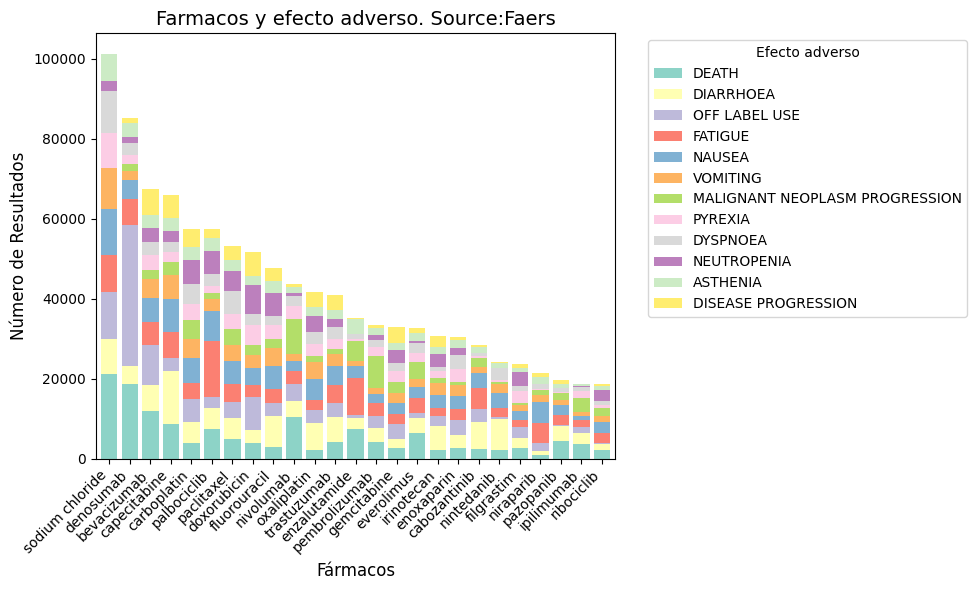

In [23]:
# Visualizar los resultados de cada farmaco en función del tipo de tumor
bar_plot_results(results_df_wide, top_farmacos)